In [26]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np

# For plotting
%matplotlib inline
import matplotlib.pyplot as plt

# For saving complex Python data structures efficiently
import pickle

# For the implementation of the neural receiver
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Layer

# Set seed for reproducable results
sn.config.seed = 42

In [27]:
# Binary source to generate uniform i.i.d. bits
binary_source = sn.utils.BinarySource()

# 256-QAM constellation
NUM_BITS_PER_SYMBOL = 6
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL, trainable=True) # The constellation is set to be trainable

# Mapper and demapper
mapper = sn.mapping.Mapper(constellation=constellation)
demapper = sn.mapping.Demapper("app", constellation=constellation)

# AWGN channel
awgn_channel = sn.channel.AWGN()

In [28]:
BATCH_SIZE = 128 # How many examples are processed by Sionna in parallel
EBN0_DB = 17.0 # Eb/N0 in dB

no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

bits = binary_source([BATCH_SIZE,
                        1200]) # Blocklength
x = mapper(bits)
y = awgn_channel([x, no])
llr = demapper([y,no])

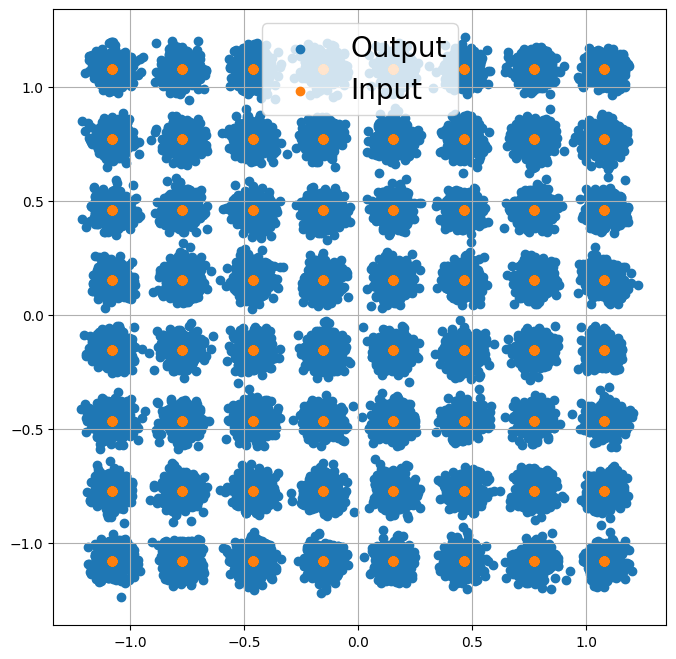

In [29]:
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1.0)
plt.grid(True)
plt.scatter(tf.math.real(y), tf.math.imag(y), label='Output')
plt.scatter(tf.math.real(x), tf.math.imag(x), label='Input')
plt.legend(fontsize=20);

In [30]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

print(f"BCE: {bce(bits, llr)}")

BCE: 0.00012394240184221417


In [31]:
with tf.GradientTape() as tape:
    bits = binary_source([BATCH_SIZE,
                            1200]) # Blocklength
    x = mapper(bits)
    y = awgn_channel([x, no])
    llr = demapper([y,no])
    loss = bce(bits, llr)

In [32]:
gradient = tape.gradient(loss, tape.watched_variables())

In [33]:
for g in gradient:
    print(g.shape)

(2, 64)


In [34]:
optimizer = tf.keras.optimizers.Adam(1e-2)

In [35]:
optimizer.apply_gradients(zip(gradient, tape.watched_variables()));

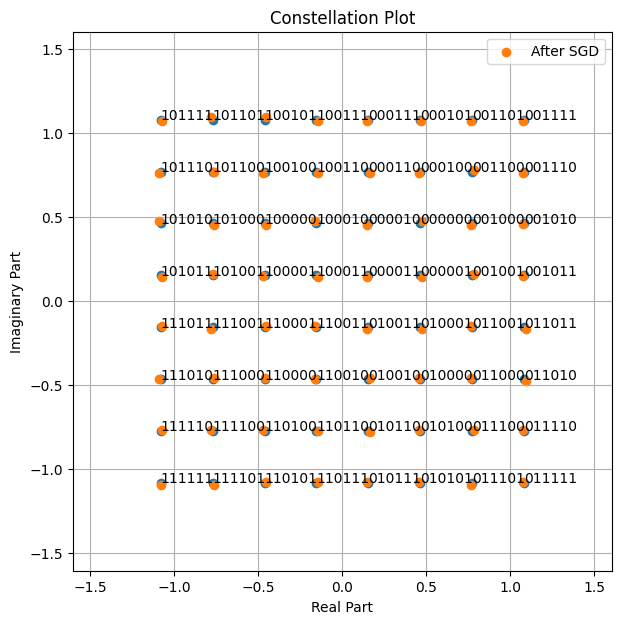

In [36]:
fig = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL).show()
fig.axes[0].scatter(tf.math.real(constellation.points), tf.math.imag(constellation.points), label='After SGD')
fig.axes[0].legend();

In [37]:
class NeuralDemapper(Layer): # Inherits from Keras Layer

    def __init__(self):
        super().__init__()

        # The three dense layers that form the custom trainable neural network-based demapper
        self.dense_1 = Dense(64, 'relu')
        self.dense_2 = Dense(64, 'relu')
        self.dense_3 = Dense(NUM_BITS_PER_SYMBOL, None) # The last layer has no activation and therefore outputs logits, i.e., LLRs

    def call(self, y):

        # y : complex-valued with shape [batch size, block length]
        # y is first mapped to a real-valued tensor with shape
        #  [batch size, block length, 2]
        # where the last dimension consists of the real and imaginary components
        # The dense layers operate on the last dimension, and treat the inner dimensions as batch dimensions, i.e.,
        # all the received symbols are independently processed.
        nn_input = tf.stack([tf.math.real(y), tf.math.imag(y)], axis=-1)
        z = self.dense_1(nn_input)
        z = self.dense_2(z)
        z = self.dense_3(z) # [batch size, number of symbols per block, number of bits per symbol]
        llr = tf.reshape(z, [tf.shape(y)[0], -1]) # [batch size, number of bits per block]
        return llr

In [38]:
class End2EndSystem(Model): # Inherits from Keras Model

    def __init__(self, training):

        super().__init__() # Must call the Keras model initializer

        self.constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL, trainable=True) # Constellation is trainable
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = NeuralDemapper() # Intantiate the NeuralDemapper custom layer as any other
        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()
        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True) # Loss function

        self.training = training

    @tf.function(jit_compile=True) # Enable graph execution to speed things up
    def __call__(self, batch_size, ebno_db):

        # no channel coding used; we set coderate=1.0
        no = sn.utils.ebnodb2no(ebno_db,
                                num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                coderate=1.0)
        bits = self.binary_source([batch_size, 1200]) # Blocklength set to 1200 bits
        x = self.mapper(bits)
        y = self.awgn_channel([x, no])
        llr = self.demapper(y)  # Call the NeuralDemapper custom layer as any other
        if self.training:
            loss = self.bce(bits, llr)
            return loss
        else:
            return bits, llr

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     10.0 | 2.6660e-02 | 1.0000e+00 |        4095 |      153600 |          128 |         128 |         0.1 |reached target block errors
   10.526 | 2.0931e-02 | 1.0000e+00 |        3215 |      153600 |          128 |         128 |         0.0 |reached target block errors
   11.053 | 1.6374e-02 | 1.0000e+00 |        2515 |      153600 |          128 |         128 |         0.0 |reached target block errors
   11.579 | 1.2305e-02 | 1.0000e+00 |        1890 |      153600 |          128 |         128 |         0.0 |reached target block errors
   12.105 | 9.2057e-03 | 9.9219e-01 |        1414 |      153600 |          127 |         128 |         0.0 |reached target block errors
   12.632 | 6.3737e-03 | 1.0000e+00 |         979 |      153600 |

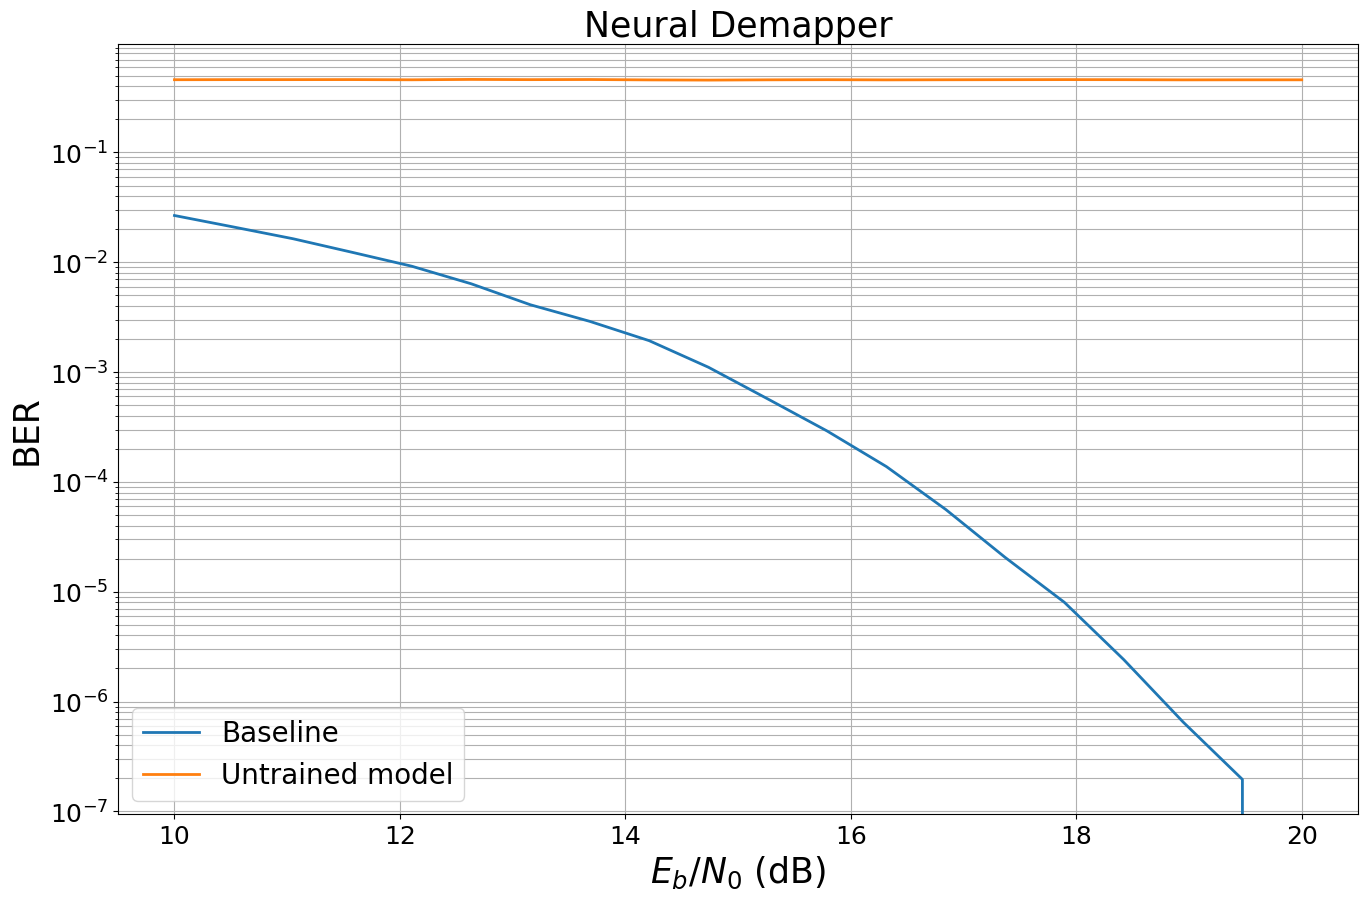

In [46]:
EBN0_DB_MIN = 10.0
EBN0_DB_MAX = 20.0


###############################
# Baseline
###############################

class Baseline(Model): # Inherits from Keras Model

    def __init__(self):

        super().__init__() # Must call the Keras model initializer

        self.constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

    @tf.function # Enable graph execution to speed things up
    def __call__(self, batch_size, ebno_db):

        # no channel coding used; we set coderate=1.0
        no = sn.utils.ebnodb2no(ebno_db,
                                num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                coderate=1.0)
        bits = self.binary_source([batch_size, 1200]) # Blocklength set to 1200 bits
        x = self.mapper(bits)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y,no])
        return bits, llr

###############################
# Benchmarking
###############################

baseline = Baseline()
model = End2EndSystem(False)
ber_plots = sn.utils.PlotBER("Neural Demapper")
ber_plots.simulate(baseline,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="Baseline",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=False);
ber_plots.simulate(model,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="Untrained model",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=True);

In [40]:
# Number of iterations used for training
NUM_TRAINING_ITERATIONS = 10000

# Set a seed for reproducibility
tf.random.set_seed(1)

# Instantiating the end-to-end model for training
model_train = End2EndSystem(training=True)

# Adam optimizer (SGD variant)
optimizer = tf.keras.optimizers.Adam()
loss_history = []
# Training loop
for i in range(NUM_TRAINING_ITERATIONS):
    # Forward pass
    with tf.GradientTape() as tape:
        loss = model_train(BATCH_SIZE, 15.0) # The model is assumed to return the BMD rate
    # Computing and applying gradients
    grads = tape.gradient(loss, model_train.trainable_weights)
    optimizer.apply_gradients(zip(grads, model_train.trainable_weights))
    # Print progress
    if i % 100 == 0:
        print(f"{i}/{NUM_TRAINING_ITERATIONS}  Loss: {loss:.2E}", end="\r")

    loss_history.append(loss.numpy())  

In [47]:
# Save the weightsin a file
weights = model_train.get_weights()
with open('weights-neural-demapper', 'wb') as f:
    pickle.dump(weights, f)

In [48]:
# Instantiating the end-to-end model for evaluation
model = End2EndSystem(training=False)
# Run one inference to build the layers and loading the weights
model(tf.constant(1, tf.int32), tf.constant(10.0, tf.float32))
with open('weights-neural-demapper', 'rb') as f:
    weights = pickle.load(f)
    model.set_weights(weights)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     10.0 | 2.6146e-02 | 1.0000e+00 |        4016 |      153600 |          128 |         128 |         0.3 |reached target block errors
   10.526 | 2.1055e-02 | 1.0000e+00 |        3234 |      153600 |          128 |         128 |         0.0 |reached target block errors
   11.053 | 1.6328e-02 | 1.0000e+00 |        2508 |      153600 |          128 |         128 |         0.0 |reached target block errors
   11.579 | 1.2337e-02 | 1.0000e+00 |        1895 |      153600 |          128 |         128 |         0.0 |reached target block errors
   12.105 | 9.0690e-03 | 1.0000e+00 |        1393 |      153600 |          128 |         128 |         0.0 |reached target block errors
   12.632 | 6.3216e-03 | 1.0000e+00 |         971 |      153600 |

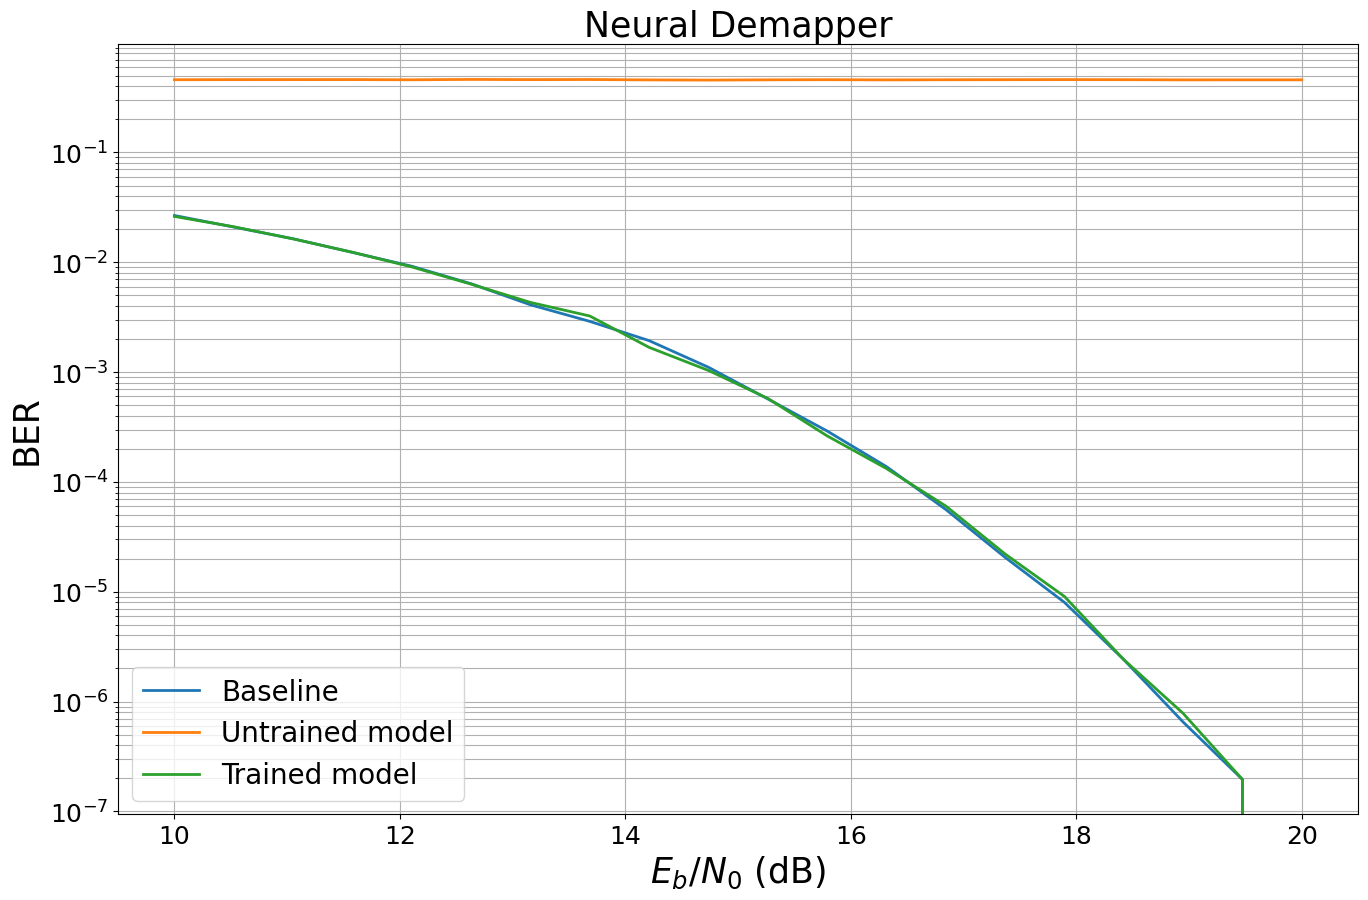

In [49]:
# Computing and plotting BER
ber_plots.simulate(model,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100,
                  legend="Trained model",
                  soft_estimates=True,
                  max_mc_iter=100,
                  show_fig=True);

plt.savefig("neural_receiver_nocode.png", dpi=300, bbox_inches="tight")  # High-resolution output

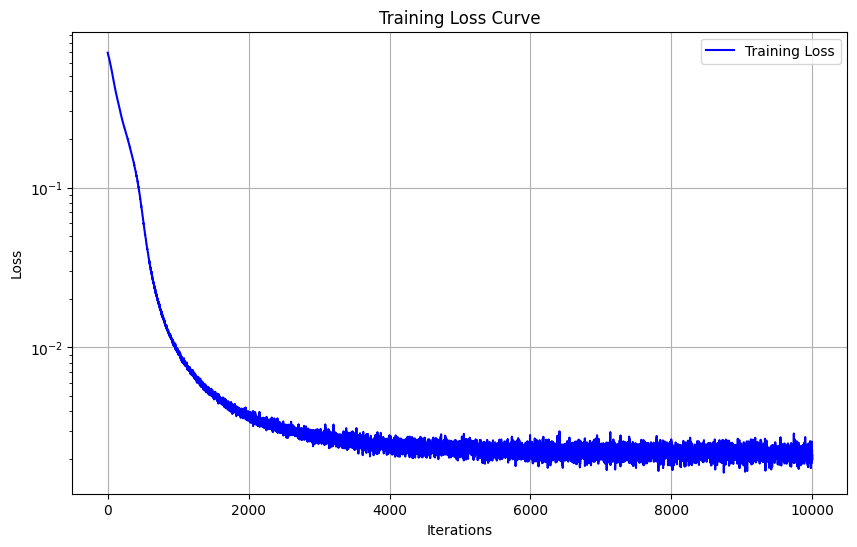

In [50]:
# Plot the training loss curve and save it
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label="Training Loss", color="blue")
plt.yscale("log")  # Set y-axis to log scale
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)

# Save the figure as a high-quality PNG file
plt.savefig("training_loss_neural_rx_nocode.png", dpi=300, bbox_inches="tight")

# Optional: Save in different formats
# plt.savefig("training_loss.pdf")  # PDF format
# plt.savefig("training_loss.svg")  # SVG format (vector graphics)

plt.show()
